# About this notebook
- Timm ResNext50_32x4d
- Alubmentation(Resized,Crop,CLAHE,Rotate,Normalize)
- Size 224
- Multi-label stratified k-Fold num=5

# Data Loading

In [1]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
os.listdir('./')

['train.log',
 'train.csv',
 'train_tfrecords',
 'kaggle.json',
 'sample_submission.csv',
 'train_annotations.csv',
 'test_tfrecords',
 'pytorch-image-models-master',
 'test',
 '.ipynb_checkpoints',
 'exp006.ipynb',
 'train',
 'api.ipynb']

In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./sample_submission.csv')
display(train.head())
display(test.head())

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0,0,0,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0,0,0,0,0,0,0,0,0,0,0


# Quick EDA

In [4]:
train['PatientID'].value_counts()

05029c63a    172
55073fece    167
26da0d5ad    148
8849382d0    130
34242119f    110
            ... 
3d1341dff      1
f39728019      1
54b4bcac6      1
542f889c8      1
58e5e24f4      1
Name: PatientID, Length: 3255, dtype: int64

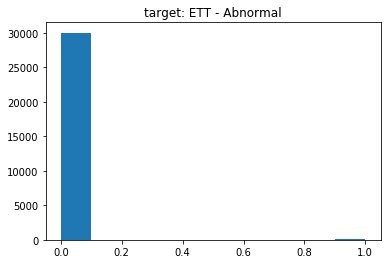

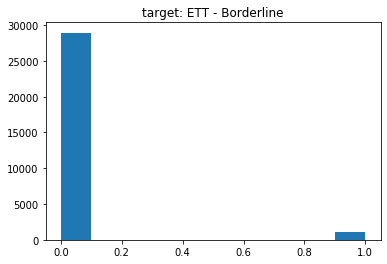

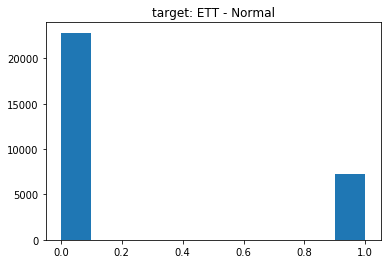

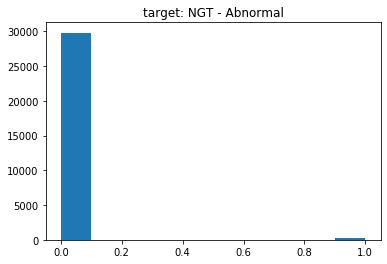

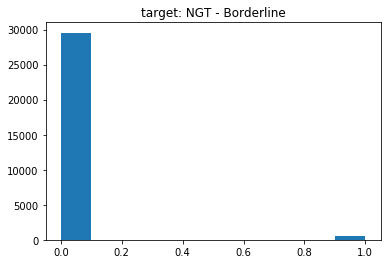

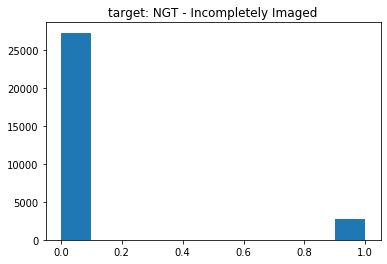

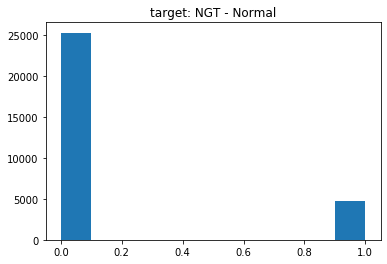

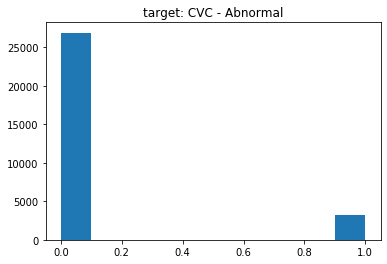

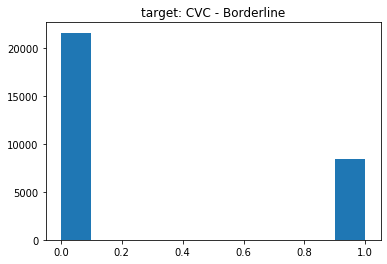

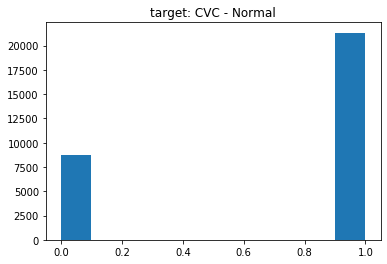

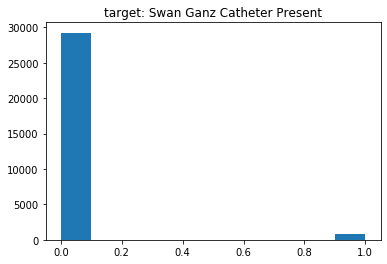

In [5]:
target_cols = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 
               'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
               'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']
for c in target_cols:
    plt.hist(train[c].values)
    plt.title(f'target: {c}')
    plt.show()

# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

#TRAIN_PATH = '../input/ranzcr-512x512-dataset'
#TRAIN_PATH = '../input/ranzcr-640x640-dataset'
TRAIN_PATH = './train'

# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    print_freq=100
    
    num_workers=4
    model_name='resnext50_32x4d'
    
    size=640 #512
    
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    
    epochs=7
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    
    batch_size=16
    
    seed=42
    
    target_size=11
    
    target_cols=['ETT - Abnormal',
                 'ETT - Borderline',
                 'ETT - Normal',
                 'NGT - Abnormal',
                 'NGT - Borderline',
                 'NGT - Incompletely Imaged',
                 'NGT - Normal', 
                 'CVC - Abnormal',
                 'CVC - Borderline',
                 'CVC - Normal',
                 'Swan Ganz Catheter Present']
    
    trn_fold=[0, 1, 2, 3, 4]
    n_fold=len(trn_fold)
    
    train=True
    annotation=False
    Filter=True
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=100, random_state=CFG.seed).reset_index(drop=True)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('./pytorch-image-models-master')

import os
import ast
import copy
import gc
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
from scipy.sparse import coo_matrix
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose,
    MotionBlur, MedianBlur, GaussianBlur,
    CLAHE, RandomGamma, OpticalDistortion, HueSaturationValue, RGBShift, ToGray
    
    )
from albumentations.pytorch import ToTensorV2,ToTensor
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('GPU:',device)

GPU: cuda


# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [10]:
def multi_label_stratified_group_k_fold(label_arr: np.array, gid_arr: np.array, n_fold: int, seed: int=42):
    """
    create multi-label stratified group kfold indexs.

    reference: https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
    input:
        label_arr: numpy.ndarray, shape = (n_train, n_class)
            multi-label for each sample's index using multi-hot vectors
        gid_arr: numpy.array, shape = (n_train,)
            group id for each sample's index
        n_fold: int. number of fold.
        seed: random seed.
    output:
        yield indexs array list for each fold's train and validation.
    """
    np.random.seed(seed)
    random.seed(seed)
    start_time = time.time()
    n_train, n_class = label_arr.shape
    gid_unique = sorted(set(gid_arr))
    n_group = len(gid_unique)

    # # aid_arr: (n_train,), indicates alternative id for group id.
    # # generally, group ids are not 0-index and continuous or not integer.
    gid2aid = dict(zip(gid_unique, range(n_group)))
#     aid2gid = dict(zip(range(n_group), gid_unique))
    aid_arr = np.vectorize(lambda x: gid2aid[x])(gid_arr)

    # # count labels by class
    cnts_by_class = label_arr.sum(axis=0)  # (n_class, )

    # # count labels by group id.
    col, row = np.array(sorted(enumerate(aid_arr), key=lambda x: x[1])).T
    cnts_by_group = coo_matrix(
        (np.ones(len(label_arr)), (row, col))
    ).dot(coo_matrix(label_arr)).toarray().astype(int)
    del col
    del row
    cnts_by_fold = np.zeros((n_fold, n_class), int)

    groups_by_fold = [[] for fid in range(n_fold)]
    group_and_cnts = list(enumerate(cnts_by_group))  # pair of aid and cnt by group
    np.random.shuffle(group_and_cnts)
    print("finished preparation", time.time() - start_time)
    for aid, cnt_by_g in sorted(group_and_cnts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for fid in range(n_fold):
            # # eval assignment.
            cnts_by_fold[fid] += cnt_by_g
            fold_eval = (cnts_by_fold / cnts_by_class).std(axis=0).mean()
            cnts_by_fold[fid] -= cnt_by_g

            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = fid

        cnts_by_fold[best_fold] += cnt_by_g
        groups_by_fold[best_fold].append(aid)
    print("finished assignment.", time.time() - start_time)

    gc.collect()
    idx_arr = np.arange(n_train)
    for fid in range(n_fold):
        val_groups = groups_by_fold[fid]

        val_indexs_bool = np.isin(aid_arr, val_groups)
        train_indexs = idx_arr[~val_indexs_bool]
        val_indexs = idx_arr[val_indexs_bool]

        print("[fold {}]".format(fid), end=" ")
        print("n_group: (train, val) = ({}, {})".format(n_group - len(val_groups), len(val_groups)), end=" ")
        print("n_sample: (train, val) = ({}, {})".format(len(train_indexs), len(val_indexs)))

        yield train_indexs, val_indexs

In [11]:
label_arr = train[CFG.target_cols].values
group_id = train.PatientID.values

train_val_indexs = \
list(multi_label_stratified_group_k_fold(label_arr, group_id, CFG.n_fold, CFG.seed))

finished preparation 0.047814369201660156
finished assignment. 0.5804779529571533
[fold 0] n_group: (train, val) = (2604, 651) n_sample: (train, val) = (24084, 5999)
[fold 1] n_group: (train, val) = (2601, 654) n_sample: (train, val) = (24104, 5979)
[fold 2] n_group: (train, val) = (2603, 652) n_sample: (train, val) = (24000, 6083)
[fold 3] n_group: (train, val) = (2605, 650) n_sample: (train, val) = (24131, 5952)
[fold 4] n_group: (train, val) = (2607, 648) n_sample: (train, val) = (24013, 6070)


In [12]:
folds = train.copy()

for n, (train_index, val_index) in enumerate(train_val_indexs):
    folds.loc[val_index, "fold"] = int(n)
    
folds.groupby('fold')[CFG.target_cols].sum()

,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
fold,,,,,,,,,,,
0.0,15,228,1448,55,105,550,960,639,1692,4265,166
1.0,16,228,1448,56,106,550,960,639,1692,4265,166
2.0,16,227,1448,56,106,550,959,639,1692,4265,166
3.0,16,228,1448,56,106,549,959,639,1692,4265,166
4.0,16,227,1448,56,106,549,959,639,1692,4264,166


# Dataset

In [13]:
train_annotations = pd.read_csv(
    './train_annotations.csv')

'''
COLOR_MAP = {'ETT - Abnormal': (255, 0, 0),
             'ETT - Borderline': (0, 255, 0),
             'ETT - Normal': (0, 0, 255),
             'NGT - Abnormal': (255, 255, 0),
             'NGT - Borderline': (255, 0, 255),
             'NGT - Incompletely Imaged': (0, 255, 255),
             'NGT - Normal': (128, 0, 0),
             'CVC - Abnormal': (0, 128, 0),
             'CVC - Borderline': (0, 0, 128),
             'CVC - Normal': (128, 128, 0),
             'Swan Ganz Catheter Present': (128, 0, 128),
            }
'''

COLOR_MAP = {'ETT - Abnormal': (0, 0, 0),
             'ETT - Borderline': (0, 0, 0),
             'ETT - Normal': (0, 0, 0),
             'NGT - Abnormal': (0, 0, 0),
             'NGT - Borderline': (0, 0, 0),
             'NGT - Incompletely Imaged': (0, 0, 0),
             'NGT - Normal': (0, 0, 0),
             'CVC - Abnormal': (0, 0, 0),
             'CVC - Borderline': (0, 0, 0),
             'CVC - Normal': (0, 128, 0),
             'Swan Ganz Catheter Present': (0, 0, 0),
            }


In [14]:
'''
# ハイパス フィルタ
adapted_filter = np.array([[-1, -1, -1],
                           [-1,  8, -1],
                           [-1, -1, -1]],np.float32)

# グラディエント フィルタ（３ｘ３）
adapted_filter = np.array([[ 1,  1,  1],
                           [ 0,  0,  0],
                           [-1, -1, -1]], np.float32)

# ラプラシアン フィルタ（３×３）
adapted_filter = np.array([[1,  1, 1],
                           [1, -8, 1],
                           [1,  1, 1]], np.float32)

# シャープ化フィルタリング
# シャープの度合い
k = 10.0
# シャープ化するためのオペレータ
adapted_filter = np.array([[0, -k, 0],
                           [-k, 1 +4*k, -k],
                           [0, -k, 0]])
'''

def highpass_filter(src, a = 0.5):
    # 高速フーリエ変換(2次元)
    src = np.fft.fft2(src)
    
    # 画像サイズ
    h, w = src.shape
   
    # 画像の中心座標
    cy, cx =  int(h/2), int(w/2)
    
    # フィルタのサイズ(矩形の高さと幅)
    rh, rw = int(a*cy), int(a*cx)

    # 第1象限と第3象限、第1象限と第4象限を入れ替え
    fsrc =  np.fft.fftshift(src)  

    # 入力画像と同じサイズで値0の配列を生成
    fdst = fsrc.copy()

    # 中心部分だけ0を代入（中心部分以外は元のまま）
    fdst[cy-rh:cy+rh, cx-rw:cx+rw] = 0
    
    # 第1象限と第3象限、第1象限と第4象限を入れ替え(元に戻す)
    fdst =  np.fft.fftshift(fdst)

    # 高速逆フーリエ変換 
    dst = np.fft.ifft2(fdst)
   
    # 実部の値のみを取り出し、符号なし整数型に変換して返す
    return  np.uint8(dst.real)

In [15]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, df_annotations=0, annot_size=30, transform=None):
        self.df = df
        self.df_annotations = df_annotations
        self.annot_size = annot_size
        self.file_names = df['StudyInstanceUID'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}.jpg' # png
        image = cv2.imread(file_path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # フィルタ
        if CFG.Filter:
            #image = cv2.filter2D(image, -1, adapted_filter)
            # ハイパスフィルタ処理
            #image = highpass_filter(image, 0.8)
            
            # バイ-ラテラルフィルタ
            #image = cv2.bilateralFilter(image,9,75,75)
            
            # ガウシアンフィルタ
            image = cv2.GaussianBlur(image,(5,5),0)
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        if CFG.annotation:
            query_string = f"StudyInstanceUID == '{file_name}'"
            df = self.df_annotations.query(query_string)
            
            for i, row in df.iterrows():
                label = row["label"]
                data = np.array(ast.literal_eval(row["data"]))
                
                for d in data:
                    image[d[1]-self.annot_size//2:d[1]+self.annot_size//2,
                          d[0]-self.annot_size//2:d[0]+self.annot_size//2,
                          :] = COLOR_MAP[label]
                    
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        label = torch.tensor(self.labels[idx]).float()
        return image, label

# Transforms

In [16]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            Resize(CFG.size, CFG.size),
            
            #RandomResizedCrop(CFG.size, CFG.size, scale=(0.80, 1.0)),
            #OneOf([RandomBrightness(limit=(-0.1,0.1)),
            #       RandomContrast(limit=(-0.1,0.1))],
            #      p=0.5,),
            #OneOf([MotionBlur(blur_limit=3),
            #       MedianBlur(blur_limit=3),
            #       GaussianBlur(blur_limit=3),],
            #      p=0.5,),
            #HorizontalFlip(p=0.5),
            
            CLAHE(clip_limit=100.0, tile_grid_size=(8, 8), p=0.5),
            #OneOf([CLAHE(clip_limit=40.0, tile_grid_size=(4, 4),p=1), CLAHE(clip_limit=100.0, tile_grid_size=(8, 8),p=1)],p=1),
            #RandomGamma(gamma_limit=(80, 120), p=1),
            #OpticalDistortion(distort_limit=0.05, shift_limit=0.05, interpolation=1, border_mode=4, p=1),
            #HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
            #RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=50, p=1),
            #RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
            #ToGray(p=1),
            
            Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225],),
            #ShiftScaleRotate(#shift_limit=0.1,scale_limit=0.1,rotate_limit=10,interpolation=cv2.INTER_LINEAR,border_mode=cv2.BORDER_REFLECT_101),
            Rotate(limit=(-5,5),interpolation=cv2.INTER_LINEAR,border_mode=cv2.BORDER_REFLECT_101,),
            ToTensorV2(),
            #ToTensor(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225],),
            ToTensorV2(),
            #ToTensor(),
        ])

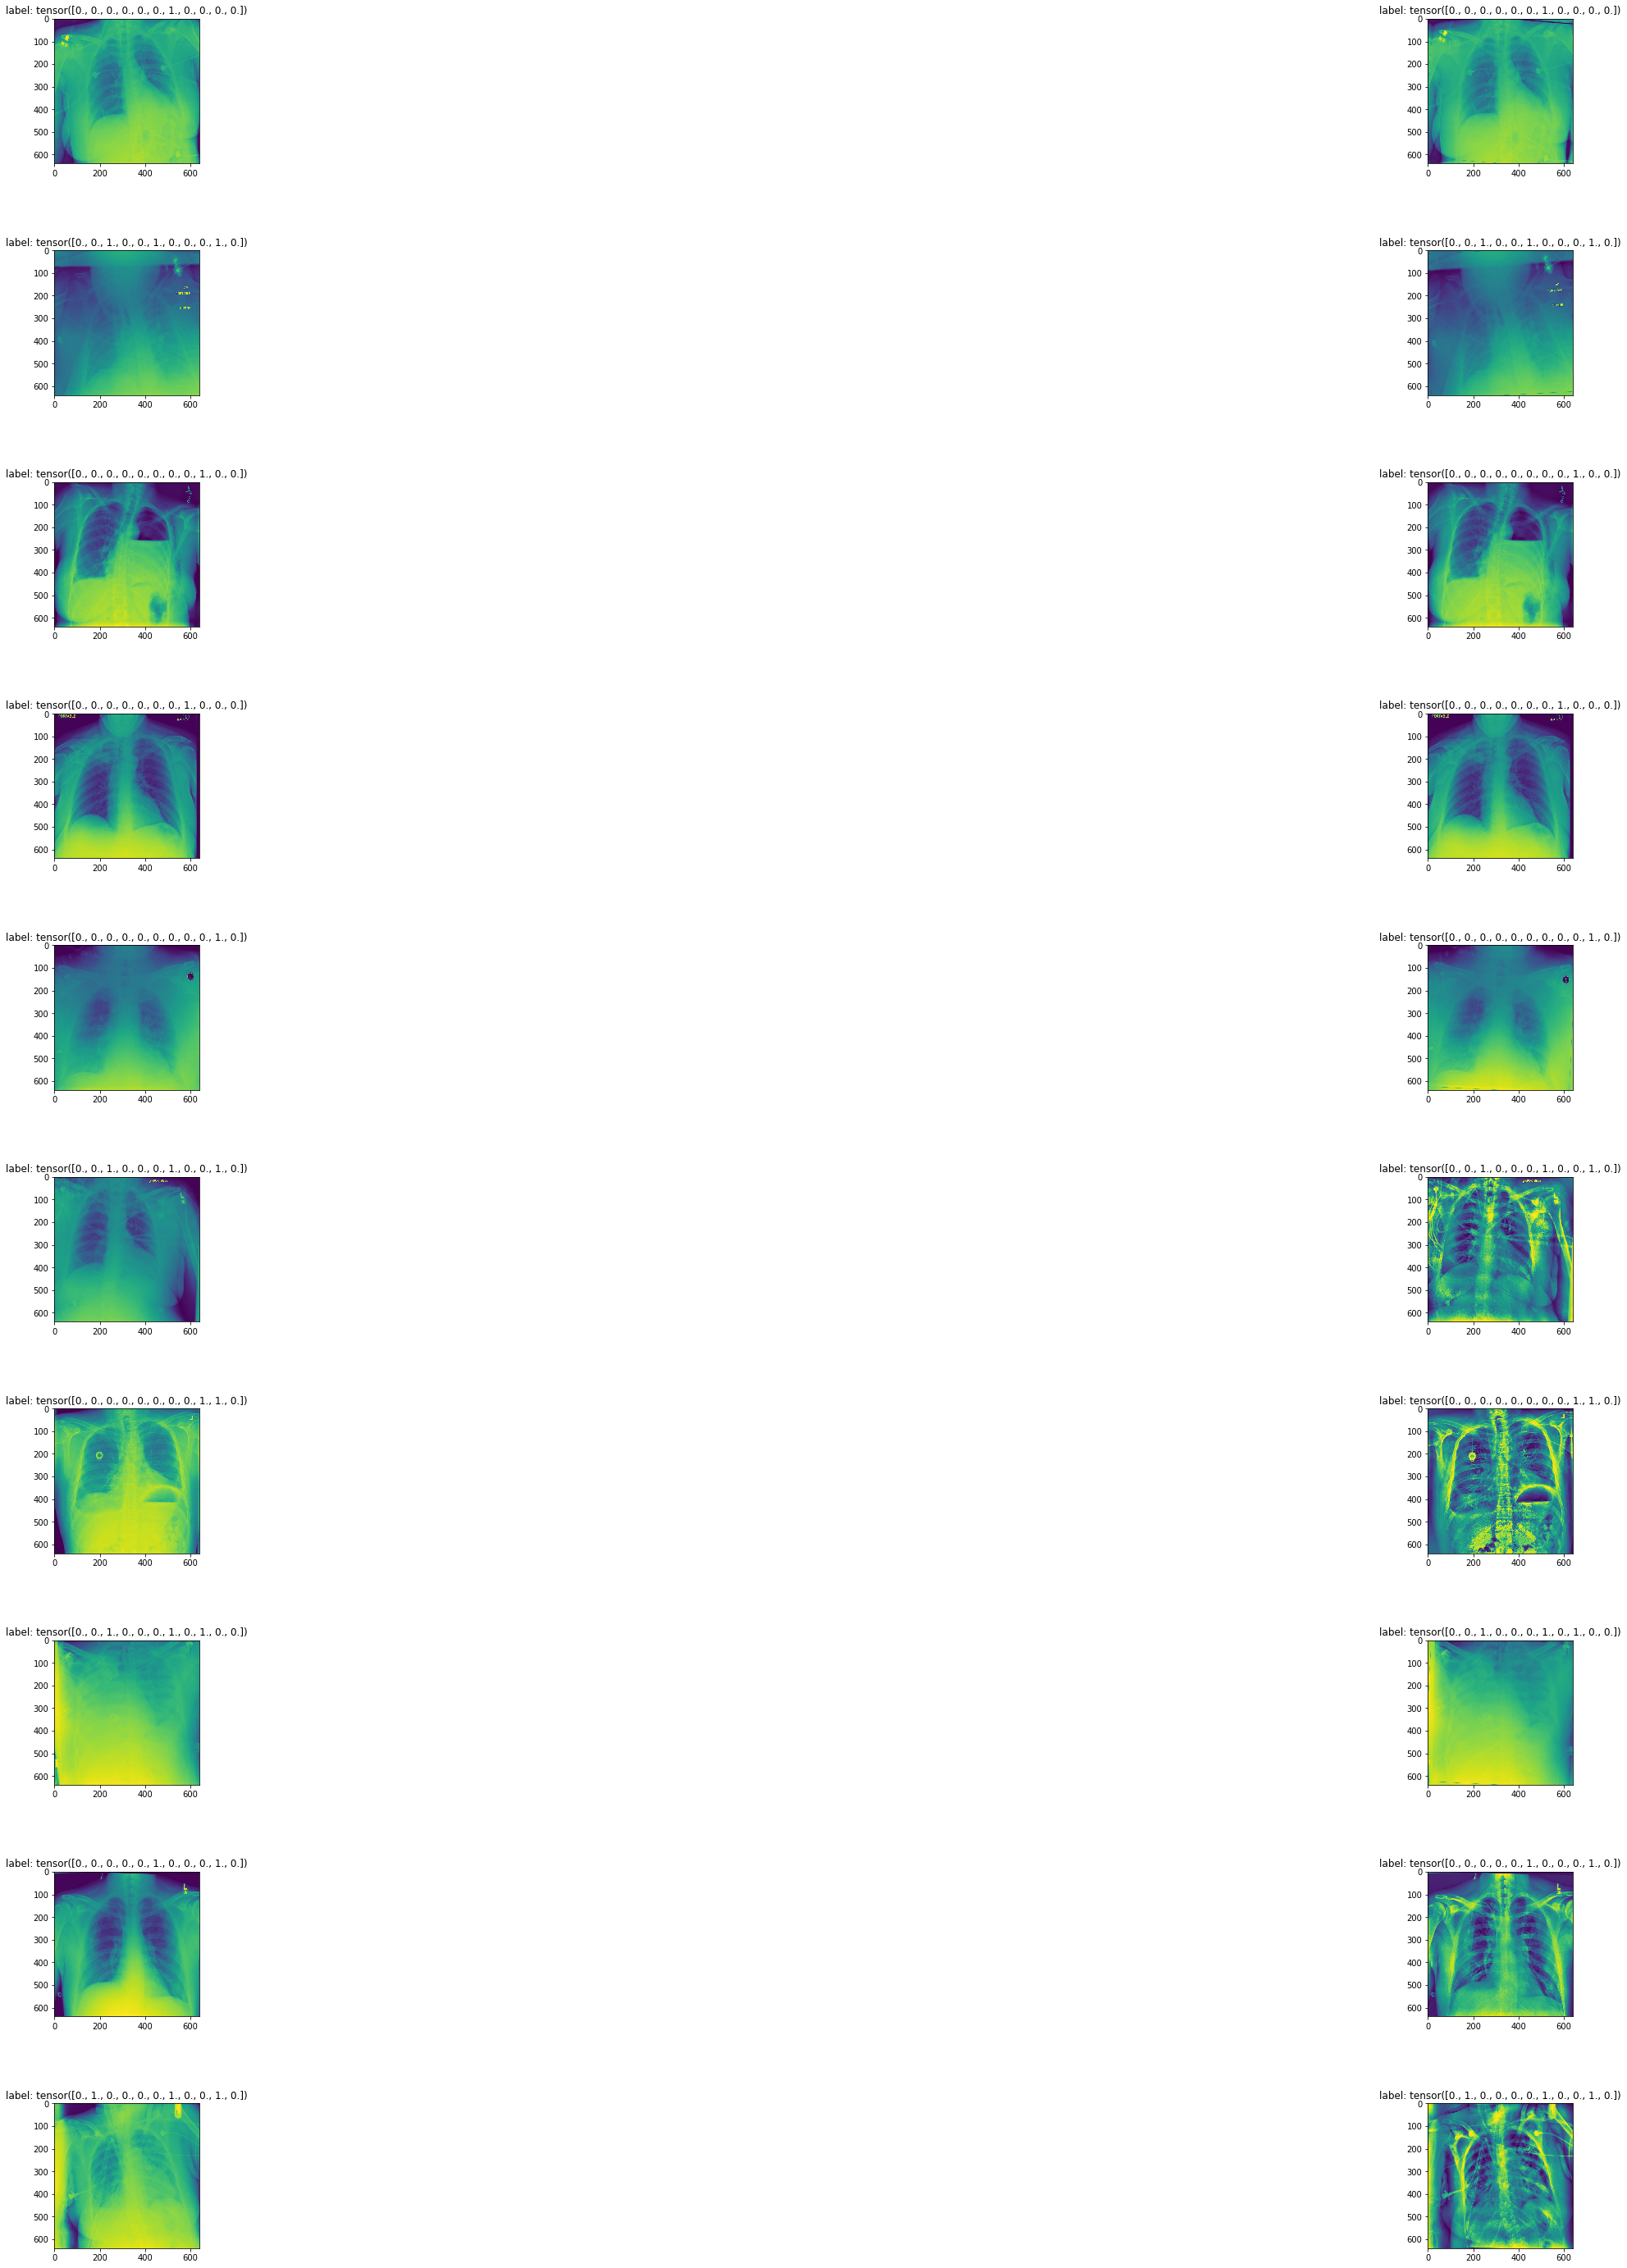

In [17]:
# CHECK Image
if CFG.annotation:
    valid_dataset = \
    TrainDataset(folds[folds['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True),
                 df_annotations=train_annotations,
                 transform=get_transforms(data='valid'))
    
    train_dataset = \
    TrainDataset(folds[folds['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True),
                 df_annotations=train_annotations,
                 transform=get_transforms(data='train'))
else:
    valid_dataset = TrainDataset(train,transform=get_transforms(data='valid'))
    train_dataset = TrainDataset(train,transform=get_transforms(data='train'))

#plt.figure(figsize=(20,20))
#plt.subplots_adjust(wspace=0.5, hspace=0.6)
figure, ax = plt.subplots(10, 2)
plt.subplots_adjust(wspace=0.5,hspace=0.6)

for i in range(10):
        
    image1, label1 = valid_dataset[i]
    #print(image1.shape)
    ax[i,0].imshow(image1[0,:,:])
    #ax[i,0].imshow(image1,'gray')
    #ax[i,0].imshow(image1)
    ax[i,0].set_title(f'label: {label1}')
        
    image2, label2 = train_dataset[i]
    #print(image2.shape)
    #ax[i,1].imshow(image2,'gray')
    ax[i,1].imshow(image2[0,:,:])
    #ax[i,1].imshow(image2)
    ax[i,1].set_title(f'label: {label2}')

figure.set_size_inches(50, 50)
plt.show();

# MODEL

In [18]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [19]:
model = CustomResNext(model_name=CFG.model_name, pretrained=False)

train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    print(image.shape)
    output = model(image)
    print(output.shape)
    print(output)
    break

torch.Size([4, 3, 640, 640])
torch.Size([4, 11])
tensor([[ 0.1710,  0.0991, -0.0129,  0.5791,  0.1429,  0.5361, -0.2067, -0.5338,
         -0.0479,  0.3912, -0.1913],
        [-0.0386,  0.0501,  0.1172,  0.2900, -0.0114,  0.2195,  0.1067, -0.2019,
         -0.0316,  0.1722, -0.0016],
        [ 0.1478,  0.0226,  0.1093,  0.4104, -0.0066,  0.3444, -0.0143, -0.3382,
         -0.0707,  0.2561, -0.0226],
        [ 0.1153,  0.0784,  0.0907,  0.3917,  0.0206,  0.3531, -0.0402, -0.3280,
         -0.0425,  0.2354, -0.0795]], grad_fn=<AddmmBackward>)


# Helper functions

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with autocast():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train loop

In [21]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    
    if CFG.annotation:
        train_folds = train_folds[train_folds['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True)
        valid_folds = valid_folds[valid_folds['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True)
        valid_labels = valid_folds[CFG.target_cols].values
        
        train_dataset = TrainDataset(train_folds,
                                     train_annotations,
                                     transform=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds,
                                     train_annotations,
                                     transform=get_transforms(data='valid'))
    
    else:
        valid_labels = valid_folds[CFG.target_cols].values
        train_dataset = TrainDataset(train_folds, 
                                     transform=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds, 
                                     transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    #optimizer = optim.SGD(model.parameters(), lr = 0.005, momentum = 0.9)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score, scores = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    for c in [f'pred_{c}' for c in CFG.target_cols]:
        valid_folds[c] = np.nan
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']

    return valid_folds

In [22]:
# ====================================================
# main
# ====================================================
def main():
    """
    Prepare: 1.train  2.folds
    """

    def get_result(result_df):
        preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
        labels = result_df[CFG.target_cols].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
                
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [23]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========


Epoch: [1][0/1505] Data 1.465 (1.465) Elapsed 0m 3s (remain 75m 39s) Loss: 0.6800(0.6800) Grad: 126836.4062  
Epoch: [1][100/1505] Data 0.000 (0.015) Elapsed 2m 11s (remain 30m 32s) Loss: 0.2545(0.3038) Grad: 79544.0156  
Epoch: [1][200/1505] Data 0.000 (0.007) Elapsed 4m 20s (remain 28m 8s) Loss: 0.2965(0.2772) Grad: 86782.6719  
Epoch: [1][300/1505] Data 0.000 (0.005) Elapsed 6m 30s (remain 26m 0s) Loss: 0.1833(0.2612) Grad: 23863.8789  
Epoch: [1][400/1505] Data 0.000 (0.004) Elapsed 8m 39s (remain 23m 49s) Loss: 0.1964(0.2515) Grad: 49367.4258  
Epoch: [1][500/1505] Data 0.000 (0.003) Elapsed 10m 48s (remain 21m 39s) Loss: 0.1547(0.2465) Grad: 32043.1895  
Epoch: [1][600/1505] Data 0.000 (0.003) Elapsed 12m 58s (remain 19m 30s) Loss: 0.1852(0.2412) Grad: 44747.7969  
Epoch: [1][700/1505] Data 0.000 (0.002) Elapsed 15m 6s (remain 17m 20s) Loss: 0.2673(0.2363) Grad: 68828.2734  
Epoch: [1][800/1505] Data 0.000 (0.002) Elapsed 17m 16s (remain 15m 11s) Loss: 0.2001(0.2322) Grad: 52285.

Epoch 1 - avg_train_loss: 0.2085  avg_val_loss: 0.1857  time: 2138s
Epoch 1 - Score: 0.8937  Scores: [0.8774 0.9184 0.9848 0.8975 0.8883 0.9572 0.9644 0.7987 0.7532 0.7925
 0.9979]
Epoch 1 - Save Best Score: 0.8937 Model


EVAL: [187/188] Data 0.000 (0.015) Elapsed 3m 9s (remain 0m 0s) Loss: 0.2836(0.1857) 


Epoch 1 - Save Best Loss: 0.1857 Model


Epoch: [2][0/1505] Data 1.379 (1.379) Elapsed 0m 2s (remain 68m 32s) Loss: 0.2522(0.2522) Grad: 61980.5156  
Epoch: [2][100/1505] Data 0.000 (0.014) Elapsed 2m 12s (remain 30m 41s) Loss: 0.1581(0.1708) Grad: 73919.3438  
Epoch: [2][200/1505] Data 0.000 (0.007) Elapsed 4m 21s (remain 28m 14s) Loss: 0.2051(0.1678) Grad: 86550.2656  
Epoch: [2][300/1505] Data 0.000 (0.005) Elapsed 6m 31s (remain 26m 5s) Loss: 0.1011(0.1672) Grad: 46566.4805  
Epoch: [2][400/1505] Data 0.000 (0.004) Elapsed 8m 39s (remain 23m 51s) Loss: 0.1721(0.1678) Grad: 51902.3281  
Epoch: [2][500/1505] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 42s) Loss: 0.1406(0.1666) Grad: 74716.6328  
Epoch: [2][600/1505] Data 0.000 (0.002) Elapsed 12m 58s (remain 19m 31s) Loss: 0.2568(0.1662) Grad: 91526.7656  
Epoch: [2][700/1505] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 21s) Loss: 0.1168(0.1649) Grad: 45908.6719  
Epoch: [2][800/1505] Data 0.000 (0.002) Elapsed 17m 17s (remain 15m 12s) Loss: 0.2204(0.1644) Grad: 73872.

Epoch 2 - avg_train_loss: 0.1636  avg_val_loss: 0.1694  time: 2139s
Epoch 2 - Score: 0.9118  Scores: [0.9189 0.925  0.9857 0.8886 0.8934 0.9696 0.975  0.8624 0.7779 0.8349
 0.9983]
Epoch 2 - Save Best Score: 0.9118 Model


EVAL: [187/188] Data 0.000 (0.014) Elapsed 3m 10s (remain 0m 0s) Loss: 0.1921(0.1694) 


Epoch 2 - Save Best Loss: 0.1694 Model


Epoch: [3][0/1505] Data 1.556 (1.556) Elapsed 0m 2s (remain 72m 52s) Loss: 0.0766(0.0766) Grad: 51167.7773  
Epoch: [3][100/1505] Data 0.000 (0.016) Elapsed 2m 12s (remain 30m 35s) Loss: 0.1632(0.1486) Grad: 61664.1289  
Epoch: [3][200/1505] Data 0.000 (0.008) Elapsed 4m 21s (remain 28m 14s) Loss: 0.1333(0.1458) Grad: 48496.0508  
Epoch: [3][300/1505] Data 0.000 (0.005) Elapsed 6m 31s (remain 26m 4s) Loss: 0.1900(0.1466) Grad: 66387.3047  
Epoch: [3][400/1505] Data 0.000 (0.004) Elapsed 8m 39s (remain 23m 50s) Loss: 0.0767(0.1443) Grad: 34805.5859  
Epoch: [3][500/1505] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 42s) Loss: 0.1270(0.1425) Grad: 64156.4766  
Epoch: [3][600/1505] Data 0.000 (0.003) Elapsed 12m 58s (remain 19m 31s) Loss: 0.0899(0.1415) Grad: 33520.9492  
Epoch: [3][700/1505] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 21s) Loss: 0.1486(0.1412) Grad: 48483.5312  
Epoch: [3][800/1505] Data 0.000 (0.002) Elapsed 17m 17s (remain 15m 11s) Loss: 0.1598(0.1414) Grad: 76032.

Epoch 3 - avg_train_loss: 0.1410  avg_val_loss: 0.1545  time: 2141s
Epoch 3 - Score: 0.9315  Scores: [0.9779 0.95   0.9882 0.9035 0.9306 0.9734 0.9783 0.8853 0.7975 0.8626
 0.9991]
Epoch 3 - Save Best Score: 0.9315 Model


EVAL: [187/188] Data 0.000 (0.014) Elapsed 3m 12s (remain 0m 0s) Loss: 0.1478(0.1545) 


Epoch 3 - Save Best Loss: 0.1545 Model


Epoch: [4][0/1505] Data 1.423 (1.423) Elapsed 0m 2s (remain 69m 42s) Loss: 0.1165(0.1165) Grad: 90251.3516  
Epoch: [4][100/1505] Data 0.000 (0.014) Elapsed 2m 11s (remain 30m 26s) Loss: 0.1340(0.1200) Grad: 49420.5586  
Epoch: [4][200/1505] Data 0.000 (0.007) Elapsed 4m 21s (remain 28m 14s) Loss: 0.0919(0.1203) Grad: 60856.2227  
Epoch: [4][300/1505] Data 0.000 (0.005) Elapsed 6m 30s (remain 26m 1s) Loss: 0.0605(0.1197) Grad: 44807.8750  
Epoch: [4][400/1505] Data 0.000 (0.004) Elapsed 8m 39s (remain 23m 50s) Loss: 0.0976(0.1205) Grad: 51041.4805  
Epoch: [4][500/1505] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 41s) Loss: 0.1925(0.1216) Grad: 103435.2891  
Epoch: [4][600/1505] Data 0.000 (0.002) Elapsed 12m 58s (remain 19m 30s) Loss: 0.0836(0.1223) Grad: 104730.3359  
Epoch: [4][700/1505] Data 0.000 (0.002) Elapsed 15m 9s (remain 17m 22s) Loss: 0.0771(0.1214) Grad: 79083.9375  
Epoch: [4][800/1505] Data 0.000 (0.002) Elapsed 17m 23s (remain 15m 17s) Loss: 0.0802(0.1217) Grad: 3943

Epoch 4 - avg_train_loss: 0.1224  avg_val_loss: 0.1519  time: 2152s
Epoch 4 - Score: 0.9376  Scores: [0.982  0.9504 0.9886 0.9165 0.946  0.9778 0.9811 0.8772 0.8153 0.8803
 0.9985]
Epoch 4 - Save Best Score: 0.9376 Model


EVAL: [187/188] Data 0.000 (0.014) Elapsed 3m 11s (remain 0m 0s) Loss: 0.1620(0.1519) 


Epoch 4 - Save Best Loss: 0.1519 Model


Epoch: [5][0/1505] Data 1.428 (1.428) Elapsed 0m 2s (remain 69m 23s) Loss: 0.1447(0.1447) Grad: 101262.0000  
Epoch: [5][100/1505] Data 0.000 (0.014) Elapsed 2m 11s (remain 30m 28s) Loss: 0.1191(0.1094) Grad: 74934.3281  
Epoch: [5][200/1505] Data 0.000 (0.007) Elapsed 4m 21s (remain 28m 17s) Loss: 0.1262(0.1052) Grad: 115137.7812  
Epoch: [5][300/1505] Data 0.000 (0.005) Elapsed 6m 30s (remain 26m 1s) Loss: 0.0723(0.1037) Grad: 46237.0117  
Epoch: [5][400/1505] Data 0.000 (0.004) Elapsed 8m 40s (remain 23m 52s) Loss: 0.1065(0.1039) Grad: 89300.9297  
Epoch: [5][500/1505] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 41s) Loss: 0.0747(0.1034) Grad: 82684.2266  
Epoch: [5][600/1505] Data 0.000 (0.002) Elapsed 12m 58s (remain 19m 31s) Loss: 0.1153(0.1031) Grad: 72413.9375  
Epoch: [5][700/1505] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 21s) Loss: 0.0839(0.1023) Grad: 66276.2422  
Epoch: [5][800/1505] Data 0.000 (0.002) Elapsed 17m 17s (remain 15m 11s) Loss: 0.1094(0.1018) Grad: 1118

Epoch 5 - avg_train_loss: 0.1015  avg_val_loss: 0.1577  time: 2140s
Epoch 5 - Score: 0.9385  Scores: [0.9851 0.9438 0.9875 0.9272 0.9465 0.9782 0.9815 0.8864 0.8082 0.8814
 0.9979]
Epoch 5 - Save Best Score: 0.9385 Model


EVAL: [187/188] Data 0.000 (0.014) Elapsed 3m 11s (remain 0m 0s) Loss: 0.1317(0.1577) 
Epoch: [6][0/1505] Data 1.495 (1.495) Elapsed 0m 2s (remain 70m 54s) Loss: 0.0521(0.0521) Grad: 58770.4453  
Epoch: [6][100/1505] Data 0.000 (0.015) Elapsed 2m 11s (remain 30m 33s) Loss: 0.0897(0.0874) Grad: 86438.4062  
Epoch: [6][200/1505] Data 0.000 (0.008) Elapsed 4m 21s (remain 28m 17s) Loss: 0.0498(0.0850) Grad: 83811.7031  
Epoch: [6][300/1505] Data 0.000 (0.005) Elapsed 6m 30s (remain 26m 2s) Loss: 0.0564(0.0842) Grad: 64519.3594  
Epoch: [6][400/1505] Data 0.000 (0.004) Elapsed 8m 40s (remain 23m 53s) Loss: 0.0646(0.0834) Grad: 102998.0000  
Epoch: [6][500/1505] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 41s) Loss: 0.0230(0.0836) Grad: 33325.5352  
Epoch: [6][600/1505] Data 0.000 (0.003) Elapsed 12m 59s (remain 19m 32s) Loss: 0.0761(0.0834) Grad: 77974.7812  
Epoch: [6][700/1505] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 21s) Loss: 0.0578(0.0825) Grad: 93098.8125  
Epoch: [6][800/150

Epoch 6 - avg_train_loss: 0.0816  avg_val_loss: 0.1647  time: 2139s
Epoch 6 - Score: 0.9394  Scores: [0.9871 0.947  0.9879 0.9341 0.9483 0.979  0.982  0.8782 0.8105 0.8809
 0.9987]
Epoch 6 - Save Best Score: 0.9394 Model


EVAL: [187/188] Data 0.000 (0.014) Elapsed 3m 10s (remain 0m 0s) Loss: 0.1107(0.1647) 
Epoch: [7][0/1505] Data 1.448 (1.448) Elapsed 0m 2s (remain 70m 17s) Loss: 0.0897(0.0897) Grad: 104750.4531  
Epoch: [7][100/1505] Data 0.000 (0.014) Elapsed 2m 12s (remain 30m 44s) Loss: 0.0770(0.0795) Grad: 83927.3047  
Epoch: [7][200/1505] Data 0.000 (0.007) Elapsed 4m 22s (remain 28m 19s) Loss: 0.0602(0.0762) Grad: 126761.9609  
Epoch: [7][300/1505] Data 0.000 (0.005) Elapsed 6m 31s (remain 26m 4s) Loss: 0.1258(0.0750) Grad: 160329.7656  
Epoch: [7][400/1505] Data 0.000 (0.004) Elapsed 8m 41s (remain 23m 55s) Loss: 0.0444(0.0750) Grad: 62588.7266  
Epoch: [7][500/1505] Data 0.000 (0.003) Elapsed 10m 50s (remain 21m 42s) Loss: 0.0629(0.0746) Grad: 130051.2188  
Epoch: [7][600/1505] Data 0.000 (0.003) Elapsed 13m 0s (remain 19m 33s) Loss: 0.1536(0.0738) Grad: 129183.8750  
Epoch: [7][700/1505] Data 0.000 (0.002) Elapsed 15m 9s (remain 17m 22s) Loss: 0.0572(0.0732) Grad: 121872.4141  
Epoch: [7][800

Epoch 7 - avg_train_loss: 0.0733  avg_val_loss: 0.1687  time: 2137s
Epoch 7 - Score: 0.9385  Scores: [0.9866 0.9418 0.9877 0.9301 0.9474 0.9783 0.9818 0.8827 0.8069 0.8812
 0.9988]


EVAL: [187/188] Data 0.000 (0.014) Elapsed 3m 8s (remain 0m 0s) Loss: 0.1245(0.1687) 


========== fold: 0 result ==========
Score: 0.9376  Scores: [0.982  0.9504 0.9886 0.9165 0.946  0.9778 0.9811 0.8772 0.8153 0.8803
 0.9985]
========== fold: 1 training ==========


Epoch: [1][0/1506] Data 1.524 (1.524) Elapsed 0m 2s (remain 73m 2s) Loss: 0.6983(0.6983) Grad: 130637.5859  
Epoch: [1][100/1506] Data 0.000 (0.015) Elapsed 2m 13s (remain 30m 53s) Loss: 0.2901(0.3128) Grad: 77168.9453  
Epoch: [1][200/1506] Data 0.000 (0.008) Elapsed 4m 21s (remain 28m 20s) Loss: 0.2620(0.2812) Grad: 62067.4375  
Epoch: [1][300/1506] Data 0.000 (0.005) Elapsed 6m 31s (remain 26m 7s) Loss: 0.2791(0.2688) Grad: 32817.0898  
Epoch: [1][400/1506] Data 0.000 (0.004) Elapsed 8m 40s (remain 23m 55s) Loss: 0.2046(0.2579) Grad: 27563.4395  
Epoch: [1][500/1506] Data 0.000 (0.003) Elapsed 10m 50s (remain 21m 43s) Loss: 0.1443(0.2490) Grad: 31181.8457  
Epoch: [1][600/1506] Data 0.000 (0.003) Elapsed 12m 59s (remain 19m 34s) Loss: 0.1288(0.2443) Grad: 24616.8242  
Epoch: [1][700/1506] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 23s) Loss: 0.1278(0.2385) Grad: 39223.5898  
Epoch: [1][800/1506] Data 0.000 (0.002) Elapsed 17m 18s (remain 15m 14s) Loss: 0.2065(0.2330) Grad: 63233.

Epoch 1 - avg_train_loss: 0.2108  avg_val_loss: 0.1916  time: 2140s
Epoch 1 - Score: 0.8901  Scores: [0.8391 0.9108 0.9811 0.8494 0.876  0.9569 0.9717 0.8246 0.7616 0.8256
 0.9937]
Epoch 1 - Save Best Score: 0.8901 Model


EVAL: [186/187] Data 0.000 (0.013) Elapsed 3m 8s (remain 0m 0s) Loss: 0.1886(0.1916) 


Epoch 1 - Save Best Loss: 0.1916 Model


Epoch: [2][0/1506] Data 1.445 (1.445) Elapsed 0m 2s (remain 70m 59s) Loss: 0.1707(0.1707) Grad: 113393.8125  
Epoch: [2][100/1506] Data 0.000 (0.014) Elapsed 2m 12s (remain 30m 46s) Loss: 0.0961(0.1725) Grad: 27559.0625  
Epoch: [2][200/1506] Data 0.000 (0.007) Elapsed 4m 21s (remain 28m 17s) Loss: 0.1385(0.1684) Grad: 65110.1289  
Epoch: [2][300/1506] Data 0.000 (0.005) Elapsed 6m 31s (remain 26m 8s) Loss: 0.1762(0.1693) Grad: 74672.5000  
Epoch: [2][400/1506] Data 0.000 (0.004) Elapsed 8m 40s (remain 23m 53s) Loss: 0.1771(0.1670) Grad: 66870.1719  
Epoch: [2][500/1506] Data 0.000 (0.003) Elapsed 10m 50s (remain 21m 44s) Loss: 0.2654(0.1670) Grad: 96364.1328  
Epoch: [2][600/1506] Data 0.000 (0.003) Elapsed 12m 59s (remain 19m 33s) Loss: 0.1443(0.1661) Grad: 51786.0547  
Epoch: [2][700/1506] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 23s) Loss: 0.1470(0.1662) Grad: 50139.4062  
Epoch: [2][800/1506] Data 0.000 (0.002) Elapsed 17m 18s (remain 15m 14s) Loss: 0.1240(0.1647) Grad: 63753

Epoch 2 - avg_train_loss: 0.1621  avg_val_loss: 0.1718  time: 2141s
Epoch 2 - Score: 0.9024  Scores: [0.8684 0.93   0.9865 0.8397 0.8749 0.9626 0.9655 0.8524 0.8008 0.8498
 0.9961]
Epoch 2 - Save Best Score: 0.9024 Model


EVAL: [186/187] Data 0.000 (0.013) Elapsed 3m 9s (remain 0m 0s) Loss: 0.1544(0.1718) 


Epoch 2 - Save Best Loss: 0.1718 Model


Epoch: [3][0/1506] Data 1.532 (1.532) Elapsed 0m 2s (remain 73m 0s) Loss: 0.1232(0.1232) Grad: 46377.0938  
Epoch: [3][100/1506] Data 0.000 (0.015) Elapsed 2m 12s (remain 30m 39s) Loss: 0.1366(0.1433) Grad: 41358.8594  
Epoch: [3][200/1506] Data 0.000 (0.008) Elapsed 4m 21s (remain 28m 15s) Loss: 0.0774(0.1440) Grad: 47371.5352  
Epoch: [3][300/1506] Data 0.000 (0.005) Elapsed 6m 31s (remain 26m 6s) Loss: 0.1761(0.1453) Grad: 63656.4531  
Epoch: [3][400/1506] Data 0.000 (0.004) Elapsed 8m 39s (remain 23m 52s) Loss: 0.3283(0.1458) Grad: 103983.9766  
Epoch: [3][500/1506] Data 0.000 (0.003) Elapsed 10m 50s (remain 21m 44s) Loss: 0.1286(0.1448) Grad: 108689.0156  
Epoch: [3][600/1506] Data 0.000 (0.003) Elapsed 12m 58s (remain 19m 32s) Loss: 0.1719(0.1450) Grad: 59784.8164  
Epoch: [3][700/1506] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 23s) Loss: 0.1587(0.1447) Grad: 83018.8281  
Epoch: [3][800/1506] Data 0.000 (0.002) Elapsed 17m 17s (remain 15m 13s) Loss: 0.2396(0.1443) Grad: 10805

Epoch 3 - avg_train_loss: 0.1423  avg_val_loss: 0.1562  time: 2159s
Epoch 3 - Score: 0.9216  Scores: [0.8922 0.945  0.9906 0.9208 0.9257 0.978  0.9826 0.8556 0.8078 0.8398
 0.9994]
Epoch 3 - Save Best Score: 0.9216 Model


EVAL: [186/187] Data 0.000 (0.013) Elapsed 3m 23s (remain 0m 0s) Loss: 0.1701(0.1562) 


Epoch 3 - Save Best Loss: 0.1562 Model


Epoch: [4][0/1506] Data 1.573 (1.573) Elapsed 0m 2s (remain 73m 6s) Loss: 0.1345(0.1345) Grad: 68314.0078  
Epoch: [4][100/1506] Data 0.000 (0.016) Elapsed 2m 11s (remain 30m 31s) Loss: 0.1362(0.1271) Grad: 90121.8281  
Epoch: [4][200/1506] Data 0.000 (0.008) Elapsed 4m 21s (remain 28m 19s) Loss: 0.1199(0.1231) Grad: 53170.5586  
Epoch: [4][300/1506] Data 0.000 (0.005) Elapsed 6m 30s (remain 26m 4s) Loss: 0.0907(0.1212) Grad: 53599.3516  
Epoch: [4][400/1506] Data 0.000 (0.004) Elapsed 8m 40s (remain 23m 53s) Loss: 0.1443(0.1211) Grad: 74292.9297  
Epoch: [4][500/1506] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 43s) Loss: 0.0962(0.1228) Grad: 63797.4727  
Epoch: [4][600/1506] Data 0.000 (0.003) Elapsed 12m 58s (remain 19m 32s) Loss: 0.0526(0.1237) Grad: 42596.0625  
Epoch: [4][700/1506] Data 0.000 (0.002) Elapsed 15m 9s (remain 17m 23s) Loss: 0.1360(0.1240) Grad: 80554.9453  
Epoch: [4][800/1506] Data 0.000 (0.002) Elapsed 17m 17s (remain 15m 13s) Loss: 0.1085(0.1235) Grad: 80663.1

Epoch 4 - avg_train_loss: 0.1231  avg_val_loss: 0.1555  time: 2154s
Epoch 4 - Score: 0.9309  Scores: [0.9038 0.948  0.9914 0.9391 0.9415 0.9818 0.9857 0.8762 0.8104 0.8624
 0.9995]
Epoch 4 - Save Best Score: 0.9309 Model


EVAL: [186/187] Data 0.000 (0.013) Elapsed 3m 10s (remain 0m 0s) Loss: 0.1743(0.1555) 


Epoch 4 - Save Best Loss: 0.1555 Model


Epoch: [5][0/1506] Data 1.521 (1.521) Elapsed 0m 2s (remain 71m 52s) Loss: 0.0753(0.0753) Grad: 55352.1328  
Epoch: [5][100/1506] Data 0.000 (0.015) Elapsed 2m 11s (remain 30m 33s) Loss: 0.0499(0.1052) Grad: 45946.5469  
Epoch: [5][200/1506] Data 0.000 (0.008) Elapsed 4m 23s (remain 28m 29s) Loss: 0.1114(0.1039) Grad: 83449.2734  
Epoch: [5][300/1506] Data 0.000 (0.005) Elapsed 6m 38s (remain 26m 34s) Loss: 0.1039(0.1023) Grad: 119008.5234  
Epoch: [5][400/1506] Data 0.000 (0.004) Elapsed 8m 53s (remain 24m 29s) Loss: 0.1140(0.1030) Grad: 90438.7031  
Epoch: [5][500/1506] Data 0.000 (0.003) Elapsed 11m 2s (remain 22m 8s) Loss: 0.1055(0.1034) Grad: 96878.9062  
Epoch: [5][600/1506] Data 0.000 (0.003) Elapsed 13m 12s (remain 19m 52s) Loss: 0.0915(0.1022) Grad: 116646.9453  
Epoch: [5][700/1506] Data 0.000 (0.002) Elapsed 15m 21s (remain 17m 38s) Loss: 0.0456(0.1016) Grad: 50935.9414  
Epoch: [5][800/1506] Data 0.000 (0.002) Elapsed 17m 30s (remain 15m 24s) Loss: 0.0667(0.1009) Grad: 7433

Epoch 5 - avg_train_loss: 0.1010  avg_val_loss: 0.1478  time: 2153s
Epoch 5 - Score: 0.9361  Scores: [0.9054 0.9589 0.9924 0.9375 0.9475 0.9829 0.986  0.8916 0.821  0.8742
 0.9996]
Epoch 5 - Save Best Score: 0.9361 Model


EVAL: [186/187] Data 0.000 (0.012) Elapsed 3m 9s (remain 0m 0s) Loss: 0.1508(0.1478) 


Epoch 5 - Save Best Loss: 0.1478 Model


Epoch: [6][0/1506] Data 1.348 (1.348) Elapsed 0m 2s (remain 67m 50s) Loss: 0.0688(0.0688) Grad: 62281.7812  
Epoch: [6][100/1506] Data 0.000 (0.013) Elapsed 2m 12s (remain 30m 39s) Loss: 0.0420(0.0857) Grad: 49828.1367  
Epoch: [6][200/1506] Data 0.000 (0.007) Elapsed 4m 25s (remain 28m 42s) Loss: 0.0829(0.0862) Grad: 81519.5000  
Epoch: [6][300/1506] Data 0.000 (0.005) Elapsed 6m 40s (remain 26m 44s) Loss: 0.1260(0.0852) Grad: 90169.4453  
Epoch: [6][400/1506] Data 0.000 (0.003) Elapsed 8m 53s (remain 24m 29s) Loss: 0.0689(0.0841) Grad: 56773.0352  
Epoch: [6][500/1506] Data 0.000 (0.003) Elapsed 11m 2s (remain 22m 8s) Loss: 0.0994(0.0841) Grad: 116869.6875  
Epoch: [6][600/1506] Data 0.000 (0.002) Elapsed 13m 13s (remain 19m 54s) Loss: 0.0741(0.0835) Grad: 105320.4922  
Epoch: [6][700/1506] Data 0.000 (0.002) Elapsed 15m 27s (remain 17m 45s) Loss: 0.0517(0.0840) Grad: 59410.7031  
Epoch: [6][800/1506] Data 0.000 (0.002) Elapsed 17m 43s (remain 15m 35s) Loss: 0.1342(0.0830) Grad: 1259

Epoch 6 - avg_train_loss: 0.0810  avg_val_loss: 0.1600  time: 2177s
Epoch 6 - Score: 0.9321  Scores: [0.8783 0.9565 0.9924 0.9347 0.9383 0.982  0.9848 0.8955 0.8185 0.8729
 0.9994]


EVAL: [186/187] Data 0.000 (0.013) Elapsed 3m 8s (remain 0m 0s) Loss: 0.1463(0.1600) 
Epoch: [7][0/1506] Data 1.522 (1.522) Elapsed 0m 2s (remain 70m 46s) Loss: 0.0289(0.0289) Grad: 46729.9844  
Epoch: [7][100/1506] Data 0.000 (0.015) Elapsed 2m 12s (remain 30m 49s) Loss: 0.0760(0.0687) Grad: 111299.9453  
Epoch: [7][200/1506] Data 0.000 (0.008) Elapsed 4m 21s (remain 28m 18s) Loss: 0.0350(0.0708) Grad: 113495.9297  
Epoch: [7][300/1506] Data 0.000 (0.005) Elapsed 6m 31s (remain 26m 8s) Loss: 0.0768(0.0685) Grad: 78676.8203  
Epoch: [7][400/1506] Data 0.000 (0.004) Elapsed 8m 40s (remain 23m 54s) Loss: 0.0390(0.0692) Grad: 107563.9922  
Epoch: [7][500/1506] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 43s) Loss: 0.1166(0.0701) Grad: 157068.3281  
Epoch: [7][600/1506] Data 0.000 (0.003) Elapsed 12m 59s (remain 19m 33s) Loss: 0.0409(0.0711) Grad: 55827.0000  
Epoch: [7][700/1506] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 23s) Loss: 0.0668(0.0716) Grad: 104156.2188  
Epoch: [7][800/

Epoch 7 - avg_train_loss: 0.0719  avg_val_loss: 0.1623  time: 2153s
Epoch 7 - Score: 0.9318  Scores: [0.8814 0.9553 0.9925 0.934  0.9398 0.9822 0.9852 0.8944 0.8144 0.8711
 0.9994]


EVAL: [186/187] Data 0.000 (0.013) Elapsed 3m 9s (remain 0m 0s) Loss: 0.1491(0.1623) 


========== fold: 1 result ==========
Score: 0.9361  Scores: [0.9054 0.9589 0.9924 0.9375 0.9475 0.9829 0.986  0.8916 0.821  0.8742
 0.9996]
========== fold: 2 training ==========


Epoch: [1][0/1500] Data 1.444 (1.444) Elapsed 0m 2s (remain 69m 58s) Loss: 0.7174(0.7174) Grad: 143192.2344  
Epoch: [1][100/1500] Data 0.000 (0.014) Elapsed 2m 12s (remain 30m 29s) Loss: 0.1794(0.3120) Grad: 63101.3555  
Epoch: [1][200/1500] Data 0.000 (0.007) Elapsed 4m 20s (remain 28m 6s) Loss: 0.1911(0.2783) Grad: 35132.6914  
Epoch: [1][300/1500] Data 0.000 (0.005) Elapsed 6m 30s (remain 25m 57s) Loss: 0.1951(0.2649) Grad: 48554.4219  
Epoch: [1][400/1500] Data 0.000 (0.004) Elapsed 8m 39s (remain 23m 43s) Loss: 0.2271(0.2557) Grad: 34731.6211  
Epoch: [1][500/1500] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 35s) Loss: 0.2592(0.2494) Grad: 47089.7383  
Epoch: [1][600/1500] Data 0.000 (0.003) Elapsed 12m 58s (remain 19m 23s) Loss: 0.1708(0.2447) Grad: 49039.1953  
Epoch: [1][700/1500] Data 0.000 (0.002) Elapsed 15m 7s (remain 17m 14s) Loss: 0.2344(0.2405) Grad: 51428.2031  
Epoch: [1][800/1500] Data 0.000 (0.002) Elapsed 17m 16s (remain 15m 4s) Loss: 0.2248(0.2361) Grad: 41709.

Epoch 1 - avg_train_loss: 0.2126  avg_val_loss: 0.1802  time: 2134s
Epoch 1 - Score: 0.8905  Scores: [0.9175 0.9134 0.9826 0.8527 0.8835 0.9691 0.9715 0.7822 0.7259 0.7998
 0.9973]
Epoch 1 - Save Best Score: 0.8905 Model


EVAL: [190/191] Data 0.000 (0.012) Elapsed 3m 13s (remain 0m 0s) Loss: 0.1145(0.1802) 


Epoch 1 - Save Best Loss: 0.1802 Model


Epoch: [2][0/1500] Data 1.622 (1.622) Elapsed 0m 2s (remain 74m 48s) Loss: 0.1964(0.1964) Grad: 43413.1367  
Epoch: [2][100/1500] Data 0.000 (0.016) Elapsed 2m 11s (remain 30m 22s) Loss: 0.2072(0.1671) Grad: 72244.5391  
Epoch: [2][200/1500] Data 0.000 (0.008) Elapsed 4m 20s (remain 28m 5s) Loss: 0.1849(0.1671) Grad: 85091.5703  
Epoch: [2][300/1500] Data 0.000 (0.006) Elapsed 6m 30s (remain 25m 54s) Loss: 0.1499(0.1671) Grad: 69033.3125  
Epoch: [2][400/1500] Data 0.000 (0.004) Elapsed 8m 38s (remain 23m 40s) Loss: 0.1661(0.1694) Grad: 49224.0078  
Epoch: [2][500/1500] Data 0.000 (0.003) Elapsed 10m 46s (remain 21m 28s) Loss: 0.2272(0.1682) Grad: 93420.3359  
Epoch: [2][600/1500] Data 0.000 (0.003) Elapsed 12m 54s (remain 19m 18s) Loss: 0.1855(0.1680) Grad: 55102.4023  
Epoch: [2][700/1500] Data 0.000 (0.002) Elapsed 15m 4s (remain 17m 10s) Loss: 0.1974(0.1665) Grad: 62586.3633  
Epoch: [2][800/1500] Data 0.000 (0.002) Elapsed 17m 12s (remain 15m 1s) Loss: 0.1435(0.1673) Grad: 71184.6

Epoch 2 - avg_train_loss: 0.1639  avg_val_loss: 0.1604  time: 2131s
Epoch 2 - Score: 0.9231  Scores: [0.9624 0.9409 0.9875 0.8932 0.9102 0.9638 0.9767 0.8634 0.7983 0.864
 0.9935]
Epoch 2 - Save Best Score: 0.9231 Model


EVAL: [190/191] Data 0.000 (0.012) Elapsed 3m 14s (remain 0m 0s) Loss: 0.0863(0.1604) 


Epoch 2 - Save Best Loss: 0.1604 Model


Epoch: [3][0/1500] Data 1.562 (1.562) Elapsed 0m 2s (remain 73m 6s) Loss: 0.1162(0.1162) Grad: 34790.3398  
Epoch: [3][100/1500] Data 0.000 (0.016) Elapsed 2m 11s (remain 30m 21s) Loss: 0.1255(0.1384) Grad: 44581.4648  
Epoch: [3][200/1500] Data 0.000 (0.008) Elapsed 4m 21s (remain 28m 9s) Loss: 0.2007(0.1436) Grad: 83249.8594  
Epoch: [3][300/1500] Data 0.000 (0.005) Elapsed 6m 30s (remain 25m 54s) Loss: 0.0824(0.1420) Grad: 52138.0898  
Epoch: [3][400/1500] Data 0.000 (0.004) Elapsed 8m 39s (remain 23m 43s) Loss: 0.1439(0.1415) Grad: 74028.8125  
Epoch: [3][500/1500] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 34s) Loss: 0.1621(0.1429) Grad: 60431.6875  
Epoch: [3][600/1500] Data 0.000 (0.003) Elapsed 12m 57s (remain 19m 23s) Loss: 0.1843(0.1436) Grad: 75456.6953  
Epoch: [3][700/1500] Data 0.000 (0.002) Elapsed 15m 7s (remain 17m 14s) Loss: 0.2324(0.1429) Grad: 77484.4141  
Epoch: [3][800/1500] Data 0.000 (0.002) Elapsed 17m 16s (remain 15m 4s) Loss: 0.1544(0.1425) Grad: 132461.1

Epoch 3 - avg_train_loss: 0.1425  avg_val_loss: 0.1545  time: 2151s
Epoch 3 - Score: 0.9297  Scores: [0.963  0.9474 0.9881 0.9047 0.9265 0.9787 0.9818 0.8702 0.7977 0.8707
 0.9985]
Epoch 3 - Save Best Score: 0.9297 Model


EVAL: [190/191] Data 0.000 (0.012) Elapsed 3m 23s (remain 0m 0s) Loss: 0.0808(0.1545) 


Epoch 3 - Save Best Loss: 0.1545 Model


Epoch: [4][0/1500] Data 1.559 (1.559) Elapsed 0m 2s (remain 72m 59s) Loss: 0.1035(0.1035) Grad: 41999.4453  
Epoch: [4][100/1500] Data 0.000 (0.016) Elapsed 2m 11s (remain 30m 25s) Loss: 0.0737(0.1233) Grad: 40412.4609  
Epoch: [4][200/1500] Data 0.000 (0.008) Elapsed 4m 23s (remain 28m 21s) Loss: 0.1502(0.1245) Grad: 90140.0391  
Epoch: [4][300/1500] Data 0.000 (0.005) Elapsed 6m 38s (remain 26m 26s) Loss: 0.1238(0.1234) Grad: 85000.3828  
Epoch: [4][400/1500] Data 0.000 (0.004) Elapsed 8m 53s (remain 24m 21s) Loss: 0.1008(0.1234) Grad: 61272.4648  
Epoch: [4][500/1500] Data 0.000 (0.003) Elapsed 11m 2s (remain 22m 0s) Loss: 0.1279(0.1221) Grad: 102795.2891  
Epoch: [4][600/1500] Data 0.000 (0.003) Elapsed 13m 11s (remain 19m 44s) Loss: 0.1348(0.1224) Grad: 59118.5742  
Epoch: [4][700/1500] Data 0.000 (0.002) Elapsed 15m 24s (remain 17m 34s) Loss: 0.1483(0.1228) Grad: 80482.9453  
Epoch: [4][800/1500] Data 0.000 (0.002) Elapsed 17m 40s (remain 15m 25s) Loss: 0.2151(0.1242) Grad: 81852

Epoch 4 - avg_train_loss: 0.1233  avg_val_loss: 0.1504  time: 2159s
Epoch 4 - Score: 0.9372  Scores: [0.9783 0.9504 0.9896 0.9211 0.9367 0.9773 0.9824 0.8769 0.8158 0.8825
 0.9983]
Epoch 4 - Save Best Score: 0.9372 Model


EVAL: [190/191] Data 0.000 (0.012) Elapsed 3m 12s (remain 0m 0s) Loss: 0.0621(0.1504) 


Epoch 4 - Save Best Loss: 0.1504 Model


Epoch: [5][0/1500] Data 1.395 (1.395) Elapsed 0m 2s (remain 68m 4s) Loss: 0.1035(0.1035) Grad: 68846.9766  
Epoch: [5][100/1500] Data 0.000 (0.014) Elapsed 2m 12s (remain 30m 32s) Loss: 0.0820(0.1068) Grad: 67732.8438  
Epoch: [5][200/1500] Data 0.000 (0.007) Elapsed 4m 21s (remain 28m 10s) Loss: 0.1055(0.1040) Grad: 67025.4531  
Epoch: [5][300/1500] Data 0.000 (0.005) Elapsed 6m 30s (remain 25m 55s) Loss: 0.0895(0.1028) Grad: 88980.6797  
Epoch: [5][400/1500] Data 0.000 (0.004) Elapsed 8m 40s (remain 23m 46s) Loss: 0.1093(0.1023) Grad: 70796.6250  
Epoch: [5][500/1500] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 34s) Loss: 0.0965(0.1017) Grad: 111076.1016  
Epoch: [5][600/1500] Data 0.000 (0.002) Elapsed 13m 0s (remain 19m 26s) Loss: 0.0883(0.1010) Grad: 112275.2266  
Epoch: [5][700/1500] Data 0.000 (0.002) Elapsed 15m 14s (remain 17m 22s) Loss: 0.1282(0.1014) Grad: 89978.0078  
Epoch: [5][800/1500] Data 0.000 (0.002) Elapsed 17m 30s (remain 15m 16s) Loss: 0.0756(0.1014) Grad: 5857

Epoch 5 - avg_train_loss: 0.1010  avg_val_loss: 0.1569  time: 2147s
Epoch 5 - Score: 0.9381  Scores: [0.984  0.9503 0.9894 0.9167 0.9326 0.9787 0.9831 0.8847 0.8202 0.8809
 0.9981]
Epoch 5 - Save Best Score: 0.9381 Model


EVAL: [190/191] Data 0.000 (0.012) Elapsed 3m 10s (remain 0m 0s) Loss: 0.0347(0.1569) 
Epoch: [6][0/1500] Data 1.450 (1.450) Elapsed 0m 2s (remain 70m 3s) Loss: 0.0444(0.0444) Grad: 105445.0391  
Epoch: [6][100/1500] Data 0.000 (0.014) Elapsed 2m 13s (remain 30m 44s) Loss: 0.1527(0.0822) Grad: 117533.6328  
Epoch: [6][200/1500] Data 0.000 (0.007) Elapsed 4m 21s (remain 28m 12s) Loss: 0.0429(0.0800) Grad: 54579.9180  
Epoch: [6][300/1500] Data 0.000 (0.005) Elapsed 6m 31s (remain 26m 0s) Loss: 0.0379(0.0816) Grad: 66491.7812  
Epoch: [6][400/1500] Data 0.000 (0.004) Elapsed 8m 41s (remain 23m 47s) Loss: 0.0873(0.0819) Grad: 115251.3750  
Epoch: [6][500/1500] Data 0.000 (0.003) Elapsed 10m 50s (remain 21m 36s) Loss: 0.0377(0.0815) Grad: 56467.6328  
Epoch: [6][600/1500] Data 0.000 (0.003) Elapsed 13m 0s (remain 19m 26s) Loss: 0.0736(0.0815) Grad: 71179.4141  
Epoch: [6][700/1500] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 16s) Loss: 0.1357(0.0818) Grad: 158531.4062  
Epoch: [6][800/15

Epoch 6 - avg_train_loss: 0.0809  avg_val_loss: 0.1630  time: 2133s
Epoch 6 - Score: 0.9381  Scores: [0.9768 0.9496 0.9894 0.9224 0.9408 0.9798 0.9842 0.8861 0.8162 0.8749
 0.9985]
Epoch 6 - Save Best Score: 0.9381 Model


EVAL: [190/191] Data 0.000 (0.012) Elapsed 3m 11s (remain 0m 0s) Loss: 0.0326(0.1630) 
Epoch: [7][0/1500] Data 1.393 (1.393) Elapsed 0m 2s (remain 68m 22s) Loss: 0.0678(0.0678) Grad: 104794.1016  
Epoch: [7][100/1500] Data 0.000 (0.014) Elapsed 2m 12s (remain 30m 40s) Loss: 0.0852(0.0779) Grad: 139953.5000  
Epoch: [7][200/1500] Data 0.000 (0.007) Elapsed 4m 21s (remain 28m 10s) Loss: 0.0782(0.0762) Grad: 125498.9688  
Epoch: [7][300/1500] Data 0.000 (0.005) Elapsed 6m 31s (remain 26m 0s) Loss: 0.0673(0.0744) Grad: 111525.6641  
Epoch: [7][400/1500] Data 0.000 (0.004) Elapsed 8m 40s (remain 23m 46s) Loss: 0.0589(0.0733) Grad: 111972.4141  
Epoch: [7][500/1500] Data 0.000 (0.003) Elapsed 10m 50s (remain 21m 36s) Loss: 0.0929(0.0729) Grad: 118731.5391  
Epoch: [7][600/1500] Data 0.000 (0.002) Elapsed 12m 59s (remain 19m 26s) Loss: 0.1070(0.0729) Grad: 114153.6797  
Epoch: [7][700/1500] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 15s) Loss: 0.0560(0.0731) Grad: 163081.6562  
Epoch: [7][

Epoch 7 - avg_train_loss: 0.0720  avg_val_loss: 0.1663  time: 2137s
Epoch 7 - Score: 0.9369  Scores: [0.9701 0.9447 0.9891 0.9207 0.9422 0.979  0.9839 0.885  0.8176 0.8753
 0.9977]


EVAL: [190/191] Data 0.000 (0.012) Elapsed 3m 12s (remain 0m 0s) Loss: 0.0268(0.1663) 


========== fold: 2 result ==========
Score: 0.9372  Scores: [0.9783 0.9504 0.9896 0.9211 0.9367 0.9773 0.9824 0.8769 0.8158 0.8825
 0.9983]
========== fold: 3 training ==========


Epoch: [1][0/1508] Data 1.543 (1.543) Elapsed 0m 2s (remain 72m 57s) Loss: 0.6994(0.6994) Grad: 116022.7031  
Epoch: [1][100/1508] Data 0.000 (0.015) Elapsed 2m 12s (remain 30m 44s) Loss: 0.2346(0.3062) Grad: 59427.6875  
Epoch: [1][200/1508] Data 0.000 (0.008) Elapsed 4m 21s (remain 28m 19s) Loss: 0.2497(0.2769) Grad: 59491.9297  
Epoch: [1][300/1508] Data 0.000 (0.005) Elapsed 6m 31s (remain 26m 9s) Loss: 0.2093(0.2628) Grad: 34278.8984  
Epoch: [1][400/1508] Data 0.000 (0.004) Elapsed 8m 39s (remain 23m 55s) Loss: 0.2387(0.2552) Grad: 44772.0703  
Epoch: [1][500/1508] Data 0.000 (0.003) Elapsed 10m 50s (remain 21m 47s) Loss: 0.2225(0.2504) Grad: 37594.4766  
Epoch: [1][600/1508] Data 0.000 (0.003) Elapsed 13m 4s (remain 19m 43s) Loss: 0.1566(0.2442) Grad: 25860.0254  
Epoch: [1][700/1508] Data 0.000 (0.002) Elapsed 15m 20s (remain 17m 39s) Loss: 0.2120(0.2405) Grad: 39796.5195  
Epoch: [1][800/1508] Data 0.000 (0.002) Elapsed 17m 30s (remain 15m 26s) Loss: 0.2642(0.2354) Grad: 72175

Epoch 1 - avg_train_loss: 0.2130  avg_val_loss: 0.1764  time: 2155s
Epoch 1 - Score: 0.9030  Scores: [0.9228 0.9343 0.9879 0.8976 0.8857 0.9674 0.9686 0.7793 0.7561 0.8439
 0.9893]
Epoch 1 - Save Best Score: 0.9030 Model


EVAL: [185/186] Data 0.000 (0.013) Elapsed 3m 9s (remain 0m 0s) Loss: 0.1796(0.1764) 


Epoch 1 - Save Best Loss: 0.1764 Model


Epoch: [2][0/1508] Data 1.405 (1.405) Elapsed 0m 2s (remain 69m 48s) Loss: 0.1545(0.1545) Grad: 57173.8984  
Epoch: [2][100/1508] Data 0.000 (0.014) Elapsed 2m 11s (remain 30m 29s) Loss: 0.1557(0.1652) Grad: 57781.3438  
Epoch: [2][200/1508] Data 0.000 (0.007) Elapsed 4m 21s (remain 28m 17s) Loss: 0.1378(0.1686) Grad: 46685.2344  
Epoch: [2][300/1508] Data 0.000 (0.005) Elapsed 6m 30s (remain 26m 5s) Loss: 0.1574(0.1707) Grad: 58519.0312  
Epoch: [2][400/1508] Data 0.000 (0.004) Elapsed 8m 39s (remain 23m 54s) Loss: 0.1336(0.1689) Grad: 56455.0547  
Epoch: [2][500/1508] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 45s) Loss: 0.2718(0.1677) Grad: 64869.0977  
Epoch: [2][600/1508] Data 0.000 (0.002) Elapsed 12m 58s (remain 19m 34s) Loss: 0.1055(0.1670) Grad: 53118.9219  
Epoch: [2][700/1508] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 25s) Loss: 0.1351(0.1667) Grad: 48897.9180  
Epoch: [2][800/1508] Data 0.000 (0.002) Elapsed 17m 16s (remain 15m 15s) Loss: 0.1372(0.1668) Grad: 49452.

Epoch 2 - avg_train_loss: 0.1642  avg_val_loss: 0.1595  time: 2142s
Epoch 2 - Score: 0.9264  Scores: [0.9418 0.9515 0.9885 0.9129 0.9119 0.9713 0.9785 0.8662 0.8012 0.8736
 0.9926]
Epoch 2 - Save Best Score: 0.9264 Model


EVAL: [185/186] Data 0.000 (0.013) Elapsed 3m 9s (remain 0m 0s) Loss: 0.1560(0.1595) 


Epoch 2 - Save Best Loss: 0.1595 Model


Epoch: [3][0/1508] Data 1.463 (1.463) Elapsed 0m 2s (remain 70m 55s) Loss: 0.1707(0.1707) Grad: 56857.9336  
Epoch: [3][100/1508] Data 0.000 (0.015) Elapsed 2m 11s (remain 30m 31s) Loss: 0.1101(0.1464) Grad: 49895.3438  
Epoch: [3][200/1508] Data 0.000 (0.007) Elapsed 4m 21s (remain 28m 21s) Loss: 0.1109(0.1460) Grad: 57554.6797  
Epoch: [3][300/1508] Data 0.000 (0.005) Elapsed 6m 30s (remain 26m 5s) Loss: 0.1376(0.1470) Grad: 63256.9922  
Epoch: [3][400/1508] Data 0.000 (0.004) Elapsed 8m 40s (remain 23m 55s) Loss: 0.1408(0.1466) Grad: 74847.3125  
Epoch: [3][500/1508] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 45s) Loss: 0.1233(0.1459) Grad: 51105.1406  
Epoch: [3][600/1508] Data 0.000 (0.003) Elapsed 12m 58s (remain 19m 34s) Loss: 0.1687(0.1449) Grad: 55986.5508  
Epoch: [3][700/1508] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 25s) Loss: 0.0859(0.1441) Grad: 46912.6367  
Epoch: [3][800/1508] Data 0.000 (0.002) Elapsed 17m 17s (remain 15m 15s) Loss: 0.1571(0.1439) Grad: 67628.

Epoch 3 - avg_train_loss: 0.1438  avg_val_loss: 0.1527  time: 2142s
Epoch 3 - Score: 0.9316  Scores: [0.9403 0.9541 0.9904 0.9029 0.9299 0.9727 0.9793 0.8933 0.8081 0.8832
 0.9936]
Epoch 3 - Save Best Score: 0.9316 Model


EVAL: [185/186] Data 0.000 (0.013) Elapsed 3m 9s (remain 0m 0s) Loss: 0.1500(0.1527) 


Epoch 3 - Save Best Loss: 0.1527 Model


Epoch: [4][0/1508] Data 1.527 (1.527) Elapsed 0m 2s (remain 72m 46s) Loss: 0.1154(0.1154) Grad: 56910.0977  
Epoch: [4][100/1508] Data 0.000 (0.015) Elapsed 2m 11s (remain 30m 37s) Loss: 0.1234(0.1239) Grad: 57187.7109  
Epoch: [4][200/1508] Data 0.000 (0.008) Elapsed 4m 21s (remain 28m 22s) Loss: 0.1353(0.1208) Grad: 63370.7734  
Epoch: [4][300/1508] Data 0.000 (0.005) Elapsed 6m 30s (remain 26m 5s) Loss: 0.0933(0.1221) Grad: 60564.8594  
Epoch: [4][400/1508] Data 0.000 (0.004) Elapsed 8m 40s (remain 23m 57s) Loss: 0.1316(0.1229) Grad: 73588.5859  
Epoch: [4][500/1508] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 45s) Loss: 0.1375(0.1238) Grad: 59479.5703  
Epoch: [4][600/1508] Data 0.000 (0.003) Elapsed 12m 59s (remain 19m 35s) Loss: 0.1572(0.1244) Grad: 90087.2266  
Epoch: [4][700/1508] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 25s) Loss: 0.1269(0.1243) Grad: 63552.5664  
Epoch: [4][800/1508] Data 0.000 (0.002) Elapsed 17m 17s (remain 15m 15s) Loss: 0.1635(0.1244) Grad: 80748.

Epoch 4 - avg_train_loss: 0.1239  avg_val_loss: 0.1443  time: 2141s
Epoch 4 - Score: 0.9426  Scores: [0.9697 0.9502 0.9894 0.924  0.9423 0.9766 0.9825 0.9078 0.8292 0.9003
 0.9967]
Epoch 4 - Save Best Score: 0.9426 Model


EVAL: [185/186] Data 0.000 (0.013) Elapsed 3m 8s (remain 0m 0s) Loss: 0.1575(0.1443) 


Epoch 4 - Save Best Loss: 0.1443 Model


Epoch: [5][0/1508] Data 1.609 (1.609) Elapsed 0m 2s (remain 74m 16s) Loss: 0.0565(0.0565) Grad: 64146.4141  
Epoch: [5][100/1508] Data 0.000 (0.016) Elapsed 2m 12s (remain 30m 46s) Loss: 0.0881(0.1087) Grad: 63617.5625  
Epoch: [5][200/1508] Data 0.000 (0.008) Elapsed 4m 25s (remain 28m 48s) Loss: 0.1487(0.1067) Grad: 74675.9609  
Epoch: [5][300/1508] Data 0.000 (0.005) Elapsed 6m 41s (remain 26m 50s) Loss: 0.0749(0.1050) Grad: 57803.0273  
Epoch: [5][400/1508] Data 0.000 (0.004) Elapsed 8m 53s (remain 24m 33s) Loss: 0.1377(0.1048) Grad: 113443.0938  
Epoch: [5][500/1508] Data 0.000 (0.003) Elapsed 11m 2s (remain 22m 11s) Loss: 0.1060(0.1043) Grad: 86175.2031  
Epoch: [5][600/1508] Data 0.000 (0.003) Elapsed 13m 12s (remain 19m 56s) Loss: 0.1386(0.1037) Grad: 87682.3594  
Epoch: [5][700/1508] Data 0.000 (0.002) Elapsed 15m 21s (remain 17m 40s) Loss: 0.0693(0.1033) Grad: 72138.9453  
Epoch: [5][800/1508] Data 0.000 (0.002) Elapsed 17m 31s (remain 15m 28s) Loss: 0.1404(0.1029) Grad: 1193

Epoch 5 - avg_train_loss: 0.1022  avg_val_loss: 0.1450  time: 2166s
Epoch 5 - Score: 0.9449  Scores: [0.9622 0.9542 0.9903 0.937  0.9499 0.9762 0.9836 0.9084 0.8333 0.9029
 0.9962]
Epoch 5 - Save Best Score: 0.9449 Model


EVAL: [185/186] Data 0.000 (0.013) Elapsed 3m 6s (remain 0m 0s) Loss: 0.1682(0.1450) 
Epoch: [6][0/1508] Data 1.527 (1.527) Elapsed 0m 2s (remain 72m 5s) Loss: 0.1483(0.1483) Grad: 117200.6641  
Epoch: [6][100/1508] Data 0.000 (0.015) Elapsed 2m 12s (remain 30m 52s) Loss: 0.1061(0.0890) Grad: 114176.2500  
Epoch: [6][200/1508] Data 0.000 (0.008) Elapsed 4m 21s (remain 28m 21s) Loss: 0.0387(0.0868) Grad: 60739.7969  
Epoch: [6][300/1508] Data 0.000 (0.005) Elapsed 6m 31s (remain 26m 11s) Loss: 0.0621(0.0842) Grad: 65060.7734  
Epoch: [6][400/1508] Data 0.000 (0.004) Elapsed 8m 40s (remain 23m 57s) Loss: 0.1063(0.0831) Grad: 121663.3047  
Epoch: [6][500/1508] Data 0.000 (0.003) Elapsed 10m 50s (remain 21m 46s) Loss: 0.1478(0.0824) Grad: 91589.1719  
Epoch: [6][600/1508] Data 0.000 (0.003) Elapsed 12m 59s (remain 19m 36s) Loss: 0.1032(0.0817) Grad: 121263.5625  
Epoch: [6][700/1508] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 25s) Loss: 0.0405(0.0818) Grad: 71346.7266  
Epoch: [6][800/1

Epoch 6 - avg_train_loss: 0.0812  avg_val_loss: 0.1553  time: 2143s
Epoch 6 - Score: 0.9446  Scores: [0.9692 0.9483 0.9896 0.9364 0.9482 0.9758 0.9833 0.9108 0.831  0.9024
 0.9958]


EVAL: [185/186] Data 0.000 (0.013) Elapsed 3m 8s (remain 0m 0s) Loss: 0.1884(0.1553) 
Epoch: [7][0/1508] Data 1.522 (1.522) Elapsed 0m 2s (remain 70m 59s) Loss: 0.0452(0.0452) Grad: 85085.9609  
Epoch: [7][100/1508] Data 0.000 (0.015) Elapsed 2m 15s (remain 31m 27s) Loss: 0.0276(0.0761) Grad: 70831.5703  
Epoch: [7][200/1508] Data 0.000 (0.008) Elapsed 4m 30s (remain 29m 22s) Loss: 0.0776(0.0744) Grad: 181051.0625  
Epoch: [7][300/1508] Data 0.000 (0.005) Elapsed 6m 44s (remain 27m 0s) Loss: 0.1233(0.0737) Grad: 202015.7344  
Epoch: [7][400/1508] Data 0.000 (0.004) Elapsed 8m 52s (remain 24m 31s) Loss: 0.0876(0.0745) Grad: 86107.9922  
Epoch: [7][500/1508] Data 0.000 (0.003) Elapsed 11m 3s (remain 22m 12s) Loss: 0.0558(0.0752) Grad: 82070.5469  
Epoch: [7][600/1508] Data 0.000 (0.003) Elapsed 13m 11s (remain 19m 54s) Loss: 0.0672(0.0747) Grad: 77446.5312  
Epoch: [7][700/1508] Data 0.000 (0.002) Elapsed 15m 21s (remain 17m 40s) Loss: 0.0581(0.0731) Grad: 84462.5234  
Epoch: [7][800/150

Epoch 7 - avg_train_loss: 0.0724  avg_val_loss: 0.1557  time: 2156s
Epoch 7 - Score: 0.9437  Scores: [0.9652 0.948  0.9897 0.9374 0.9471 0.976  0.9834 0.9076 0.8296 0.9007
 0.996 ]


EVAL: [185/186] Data 0.000 (0.013) Elapsed 3m 10s (remain 0m 0s) Loss: 0.1922(0.1557) 


========== fold: 3 result ==========
Score: 0.9426  Scores: [0.9697 0.9502 0.9894 0.924  0.9423 0.9766 0.9825 0.9078 0.8292 0.9003
 0.9967]
========== fold: 4 training ==========


Epoch: [1][0/1500] Data 1.488 (1.488) Elapsed 0m 2s (remain 70m 43s) Loss: 0.6904(0.6904) Grad: 187198.5781  
Epoch: [1][100/1500] Data 0.000 (0.015) Elapsed 2m 11s (remain 30m 19s) Loss: 0.2023(0.3022) Grad: 47820.7305  
Epoch: [1][200/1500] Data 0.000 (0.008) Elapsed 4m 20s (remain 28m 5s) Loss: 0.2230(0.2735) Grad: 41028.6914  
Epoch: [1][300/1500] Data 0.000 (0.005) Elapsed 6m 30s (remain 25m 53s) Loss: 0.2148(0.2621) Grad: 34003.0273  
Epoch: [1][400/1500] Data 0.000 (0.004) Elapsed 8m 39s (remain 23m 42s) Loss: 0.2121(0.2556) Grad: 49090.7500  
Epoch: [1][500/1500] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 34s) Loss: 0.2775(0.2477) Grad: 51082.9766  
Epoch: [1][600/1500] Data 0.000 (0.003) Elapsed 12m 57s (remain 19m 23s) Loss: 0.2903(0.2412) Grad: 80438.1250  
Epoch: [1][700/1500] Data 0.000 (0.002) Elapsed 15m 7s (remain 17m 14s) Loss: 0.1662(0.2355) Grad: 39569.8789  
Epoch: [1][800/1500] Data 0.000 (0.002) Elapsed 17m 16s (remain 15m 4s) Loss: 0.1556(0.2300) Grad: 49269.

Epoch 1 - avg_train_loss: 0.2094  avg_val_loss: 0.1777  time: 2134s
Epoch 1 - Score: 0.8983  Scores: [0.8823 0.9197 0.9825 0.9087 0.8835 0.965  0.967  0.7916 0.7552 0.8332
 0.9923]
Epoch 1 - Save Best Score: 0.8983 Model


EVAL: [189/190] Data 0.000 (0.013) Elapsed 3m 14s (remain 0m 0s) Loss: 0.1650(0.1777) 


Epoch 1 - Save Best Loss: 0.1777 Model


Epoch: [2][0/1500] Data 1.595 (1.595) Elapsed 0m 2s (remain 73m 4s) Loss: 0.1234(0.1234) Grad: 44847.5508  
Epoch: [2][100/1500] Data 0.000 (0.016) Elapsed 2m 11s (remain 30m 21s) Loss: 0.1215(0.1638) Grad: 52760.3984  
Epoch: [2][200/1500] Data 0.000 (0.008) Elapsed 4m 21s (remain 28m 10s) Loss: 0.1104(0.1617) Grad: 33464.6602  
Epoch: [2][300/1500] Data 0.000 (0.005) Elapsed 6m 30s (remain 25m 54s) Loss: 0.2232(0.1606) Grad: 45590.3164  
Epoch: [2][400/1500] Data 0.000 (0.004) Elapsed 8m 39s (remain 23m 44s) Loss: 0.1576(0.1602) Grad: 39391.4922  
Epoch: [2][500/1500] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 34s) Loss: 0.1790(0.1607) Grad: 59682.5273  
Epoch: [2][600/1500] Data 0.000 (0.003) Elapsed 12m 58s (remain 19m 24s) Loss: 0.2328(0.1597) Grad: 67299.9141  
Epoch: [2][700/1500] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 15s) Loss: 0.2427(0.1603) Grad: 73993.8438  
Epoch: [2][800/1500] Data 0.000 (0.002) Elapsed 17m 16s (remain 15m 4s) Loss: 0.1048(0.1603) Grad: 33020.0

Epoch 2 - avg_train_loss: 0.1570  avg_val_loss: 0.1707  time: 2135s
Epoch 2 - Score: 0.9159  Scores: [0.9138 0.9456 0.9885 0.9079 0.9163 0.9662 0.9721 0.8434 0.7593 0.8647
 0.9977]
Epoch 2 - Save Best Score: 0.9159 Model


EVAL: [189/190] Data 0.000 (0.013) Elapsed 3m 13s (remain 0m 0s) Loss: 0.1671(0.1707) 


Epoch 2 - Save Best Loss: 0.1707 Model


Epoch: [3][0/1500] Data 1.492 (1.492) Elapsed 0m 2s (remain 71m 5s) Loss: 0.1620(0.1620) Grad: 65989.7812  
Epoch: [3][100/1500] Data 0.000 (0.015) Elapsed 2m 11s (remain 30m 25s) Loss: 0.1363(0.1333) Grad: 73517.1797  
Epoch: [3][200/1500] Data 0.000 (0.008) Elapsed 4m 22s (remain 28m 13s) Loss: 0.1692(0.1399) Grad: 85022.9531  
Epoch: [3][300/1500] Data 0.000 (0.005) Elapsed 6m 30s (remain 25m 56s) Loss: 0.1911(0.1403) Grad: 75529.3750  
Epoch: [3][400/1500] Data 0.000 (0.004) Elapsed 8m 40s (remain 23m 47s) Loss: 0.0984(0.1406) Grad: 42556.8945  
Epoch: [3][500/1500] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 35s) Loss: 0.1468(0.1403) Grad: 83670.4609  
Epoch: [3][600/1500] Data 0.000 (0.003) Elapsed 12m 58s (remain 19m 25s) Loss: 0.1670(0.1411) Grad: 73123.8359  
Epoch: [3][700/1500] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 15s) Loss: 0.2086(0.1409) Grad: 74387.0703  
Epoch: [3][800/1500] Data 0.000 (0.002) Elapsed 17m 17s (remain 15m 5s) Loss: 0.1672(0.1414) Grad: 80198.9

Epoch 3 - avg_train_loss: 0.1411  avg_val_loss: 0.1555  time: 2135s
Epoch 3 - Score: 0.9290  Scores: [0.949  0.9479 0.9886 0.9315 0.9201 0.9747 0.9756 0.8484 0.8017 0.8837
 0.9981]
Epoch 3 - Save Best Score: 0.9290 Model


EVAL: [189/190] Data 0.000 (0.013) Elapsed 3m 12s (remain 0m 0s) Loss: 0.1442(0.1555) 


Epoch 3 - Save Best Loss: 0.1555 Model


Epoch: [4][0/1500] Data 1.466 (1.466) Elapsed 0m 2s (remain 70m 56s) Loss: 0.0550(0.0550) Grad: 35481.5312  
Epoch: [4][100/1500] Data 0.000 (0.015) Elapsed 2m 11s (remain 30m 28s) Loss: 0.1373(0.1241) Grad: 86278.2969  
Epoch: [4][200/1500] Data 0.000 (0.007) Elapsed 4m 21s (remain 28m 11s) Loss: 0.0744(0.1227) Grad: 62489.0547  
Epoch: [4][300/1500] Data 0.000 (0.005) Elapsed 6m 30s (remain 25m 55s) Loss: 0.1284(0.1242) Grad: 69325.3984  
Epoch: [4][400/1500] Data 0.000 (0.004) Elapsed 8m 40s (remain 23m 46s) Loss: 0.0750(0.1242) Grad: 55353.5820  
Epoch: [4][500/1500] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 34s) Loss: 0.1211(0.1234) Grad: 73037.7891  
Epoch: [4][600/1500] Data 0.000 (0.003) Elapsed 12m 59s (remain 19m 25s) Loss: 0.1368(0.1231) Grad: 105583.8125  
Epoch: [4][700/1500] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 15s) Loss: 0.1675(0.1231) Grad: 102876.4297  
Epoch: [4][800/1500] Data 0.000 (0.002) Elapsed 17m 17s (remain 15m 5s) Loss: 0.2140(0.1227) Grad: 1011

Epoch 4 - avg_train_loss: 0.1225  avg_val_loss: 0.1552  time: 2147s
Epoch 4 - Score: 0.9352  Scores: [0.9728 0.9508 0.9888 0.936  0.9355 0.9772 0.9781 0.8594 0.8037 0.8864
 0.9982]
Epoch 4 - Save Best Score: 0.9352 Model


EVAL: [189/190] Data 0.000 (0.013) Elapsed 3m 12s (remain 0m 0s) Loss: 0.1338(0.1552) 


Epoch 4 - Save Best Loss: 0.1552 Model


Epoch: [5][0/1500] Data 1.540 (1.540) Elapsed 0m 2s (remain 71m 55s) Loss: 0.0893(0.0893) Grad: 91790.6328  
Epoch: [5][100/1500] Data 0.000 (0.015) Elapsed 2m 12s (remain 30m 40s) Loss: 0.1168(0.0969) Grad: 92303.8438  
Epoch: [5][200/1500] Data 0.000 (0.008) Elapsed 4m 21s (remain 28m 11s) Loss: 0.0755(0.0998) Grad: 90216.0234  
Epoch: [5][300/1500] Data 0.000 (0.005) Elapsed 6m 31s (remain 25m 57s) Loss: 0.1156(0.0997) Grad: 128723.2109  
Epoch: [5][400/1500] Data 0.000 (0.004) Elapsed 8m 40s (remain 23m 47s) Loss: 0.1036(0.1007) Grad: 83534.9531  
Epoch: [5][500/1500] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 35s) Loss: 0.0901(0.1008) Grad: 63212.4375  
Epoch: [5][600/1500] Data 0.000 (0.003) Elapsed 12m 59s (remain 19m 26s) Loss: 0.0874(0.1013) Grad: 103145.0000  
Epoch: [5][700/1500] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 15s) Loss: 0.0494(0.1006) Grad: 77637.7891  
Epoch: [5][800/1500] Data 0.000 (0.002) Elapsed 17m 18s (remain 15m 6s) Loss: 0.1162(0.1005) Grad: 8457

Epoch 5 - avg_train_loss: 0.1004  avg_val_loss: 0.1579  time: 2134s
Epoch 5 - Score: 0.9370  Scores: [0.9674 0.9517 0.9888 0.9455 0.9187 0.9768 0.9786 0.8698 0.8159 0.8952
 0.9984]
Epoch 5 - Save Best Score: 0.9370 Model


EVAL: [189/190] Data 0.000 (0.013) Elapsed 3m 10s (remain 0m 0s) Loss: 0.1693(0.1579) 
Epoch: [6][0/1500] Data 1.549 (1.549) Elapsed 0m 2s (remain 73m 3s) Loss: 0.0972(0.0972) Grad: 126236.9609  
Epoch: [6][100/1500] Data 0.000 (0.015) Elapsed 2m 13s (remain 30m 44s) Loss: 0.0566(0.0848) Grad: 62377.7656  
Epoch: [6][200/1500] Data 0.000 (0.008) Elapsed 4m 21s (remain 28m 11s) Loss: 0.0364(0.0825) Grad: 79341.2344  
Epoch: [6][300/1500] Data 0.000 (0.005) Elapsed 6m 31s (remain 25m 59s) Loss: 0.0873(0.0816) Grad: 83397.1406  
Epoch: [6][400/1500] Data 0.000 (0.004) Elapsed 8m 40s (remain 23m 46s) Loss: 0.0419(0.0815) Grad: 59714.5508  
Epoch: [6][500/1500] Data 0.000 (0.003) Elapsed 10m 49s (remain 21m 35s) Loss: 0.0468(0.0815) Grad: 174067.5938  
Epoch: [6][600/1500] Data 0.000 (0.003) Elapsed 12m 59s (remain 19m 26s) Loss: 0.0977(0.0809) Grad: 127299.1250  
Epoch: [6][700/1500] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 15s) Loss: 0.0445(0.0805) Grad: 108584.0312  
Epoch: [6][800/

Epoch 6 - avg_train_loss: 0.0800  avg_val_loss: 0.1699  time: 2134s
Epoch 6 - Score: 0.9350  Scores: [0.9696 0.9465 0.9881 0.9464 0.9201 0.976  0.9781 0.8634 0.8094 0.8888
 0.9984]


EVAL: [189/190] Data 0.000 (0.013) Elapsed 3m 10s (remain 0m 0s) Loss: 0.1765(0.1699) 
Epoch: [7][0/1500] Data 1.458 (1.458) Elapsed 0m 2s (remain 68m 47s) Loss: 0.1090(0.1090) Grad: 104121.2812  
Epoch: [7][100/1500] Data 0.000 (0.015) Elapsed 2m 12s (remain 30m 38s) Loss: 0.0466(0.0757) Grad: 107415.2891  
Epoch: [7][200/1500] Data 0.000 (0.007) Elapsed 4m 21s (remain 28m 9s) Loss: 0.0740(0.0733) Grad: 81500.9219  
Epoch: [7][300/1500] Data 0.000 (0.005) Elapsed 6m 31s (remain 26m 0s) Loss: 0.1081(0.0714) Grad: 129330.2812  
Epoch: [7][400/1500] Data 0.000 (0.004) Elapsed 8m 40s (remain 23m 46s) Loss: 0.0503(0.0712) Grad: 83181.8750  
Epoch: [7][500/1500] Data 0.000 (0.003) Elapsed 10m 50s (remain 21m 36s) Loss: 0.0900(0.0711) Grad: 136349.3281  
Epoch: [7][600/1500] Data 0.000 (0.003) Elapsed 12m 59s (remain 19m 25s) Loss: 0.0471(0.0713) Grad: 97055.6250  
Epoch: [7][700/1500] Data 0.000 (0.002) Elapsed 15m 8s (remain 17m 15s) Loss: 0.0615(0.0718) Grad: 84973.1797  
Epoch: [7][800/1

Epoch 7 - avg_train_loss: 0.0716  avg_val_loss: 0.1687  time: 2136s
Epoch 7 - Score: 0.9347  Scores: [0.9698 0.9467 0.9879 0.9435 0.9188 0.9763 0.9788 0.8643 0.8083 0.8889
 0.9982]


EVAL: [189/190] Data 0.000 (0.013) Elapsed 3m 12s (remain 0m 0s) Loss: 0.1740(0.1687) 


========== fold: 4 result ==========
Score: 0.9352  Scores: [0.9728 0.9508 0.9888 0.936  0.9355 0.9772 0.9781 0.8594 0.8037 0.8864
 0.9982]
========== CV ==========
Score: 0.9366  Scores: [0.9584 0.9502 0.9896 0.9263 0.941  0.9777 0.9818 0.8813 0.8144 0.8833
 0.9982]
